<a href="https://colab.research.google.com/github/Jahnvi99/Leuphana-Intern/blob/master/GP_LCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gpytorch

     |████████████████████████████████| 501kB 2.9MB/s 


In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import numpy as np
from scipy.integrate import simps
from numpy import trapz
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))  
mean = 0.0
std = 1.0

def gaussian_2(x):
  return (torch.tensor(norm.pdf(x))).float()   

X = torch.linspace(-3, 3, 1200)
y = gaussian_2(X)

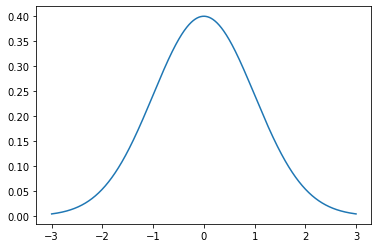

In [4]:
plt.plot(X,y)
plt.show()

In [5]:
trapz(y, dx=0.005)

0.99646914

In [6]:
class QuadraticMean(gpytorch.means.Mean):
    def __init__(self):
        self.a = -2.

    def forward(self, x):
        return self.a * x.norm(dim = -1)

In [7]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [9]:
X_sample = torch.tensor([ 1.3567,  2.2485, -2.6980])
y_sample = gaussian_2(X_sample)

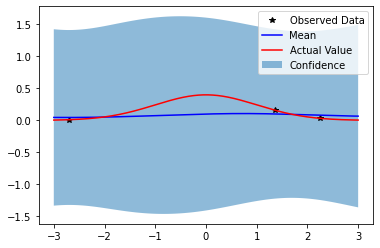

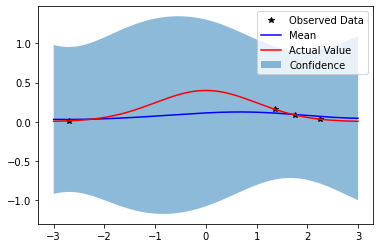

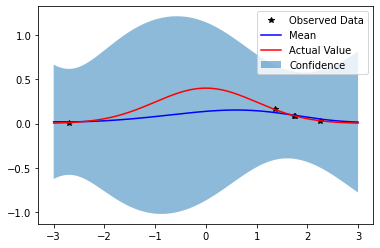

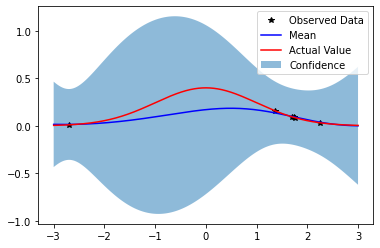

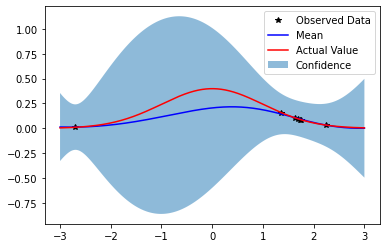

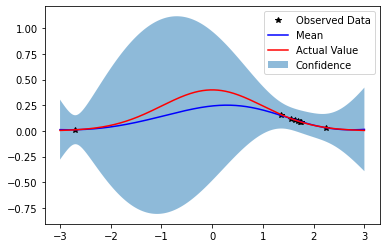

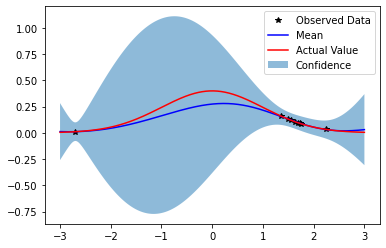

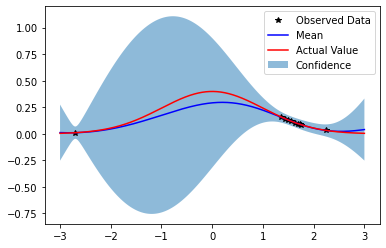

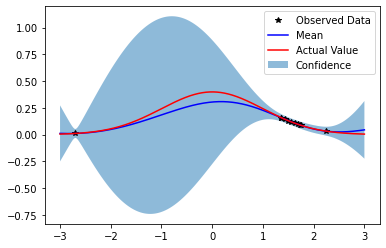

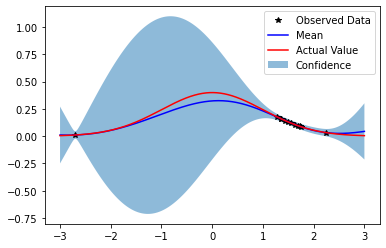

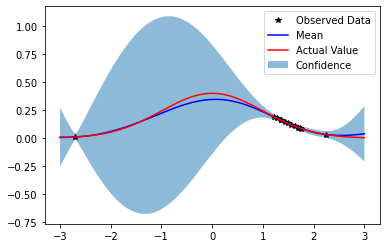

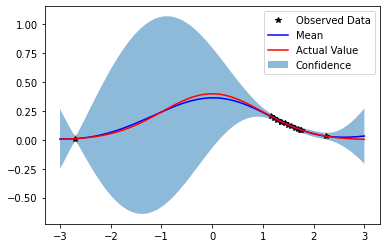

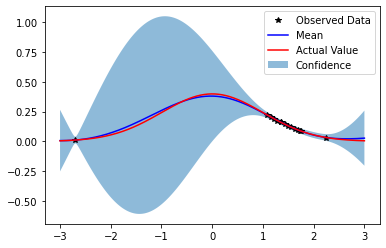

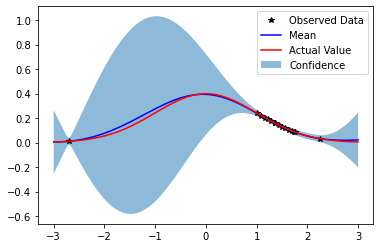

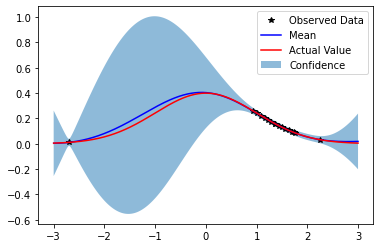

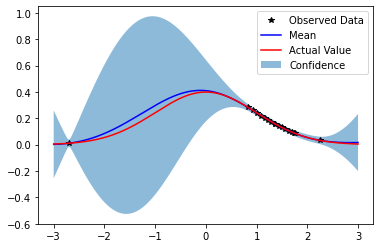

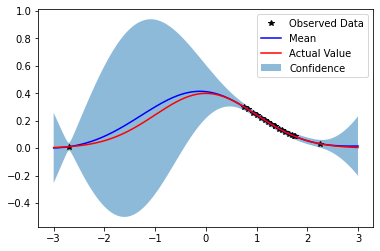

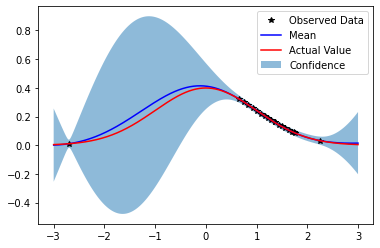

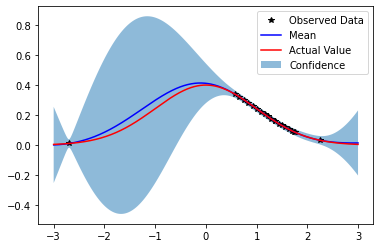

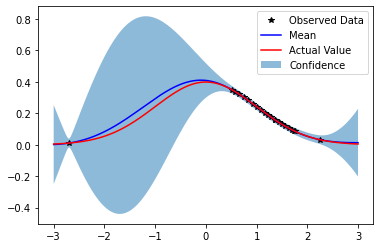

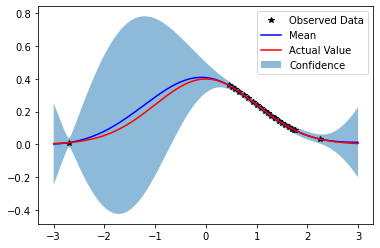

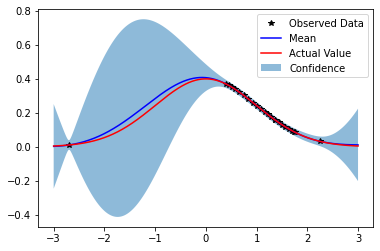

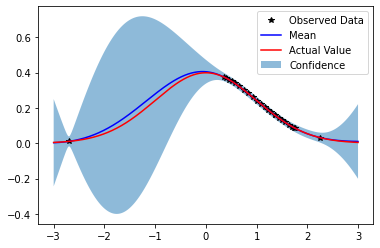

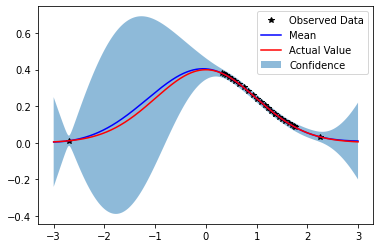

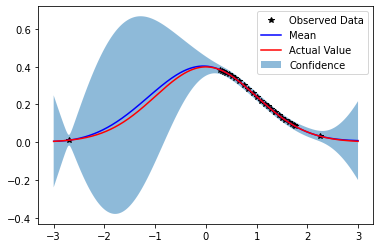

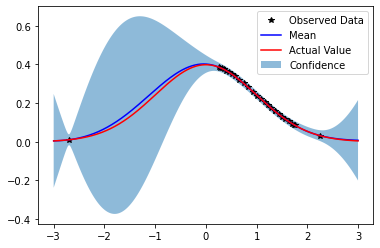

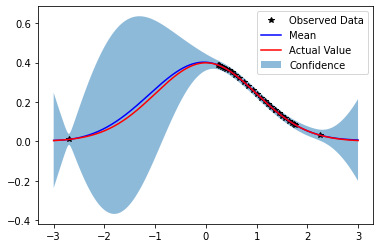

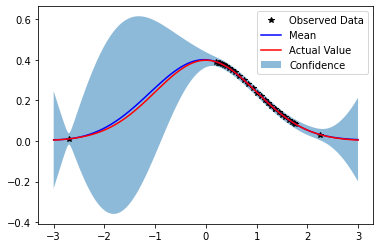

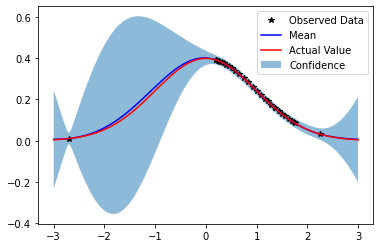

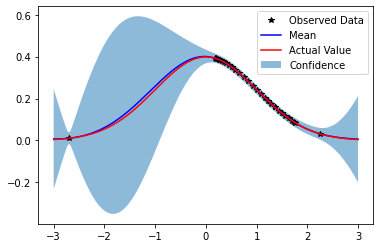

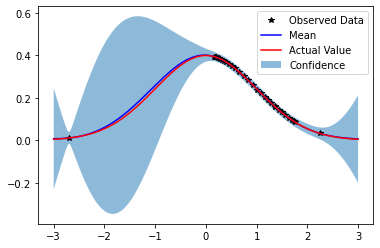

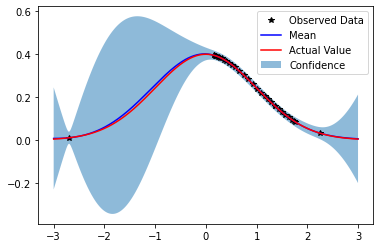

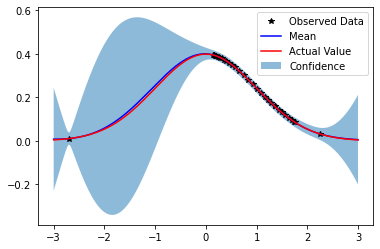

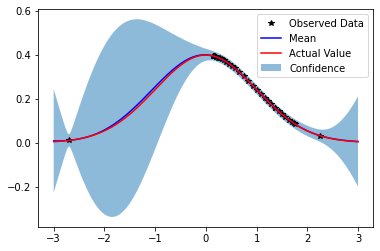

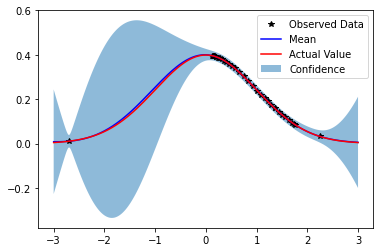

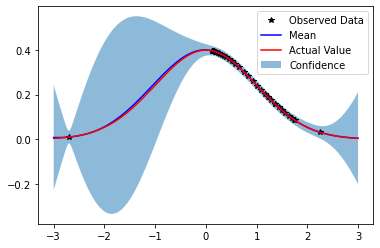

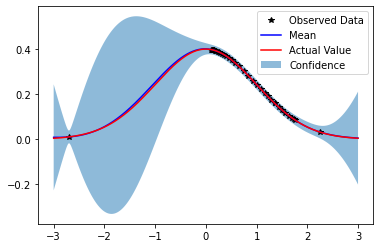

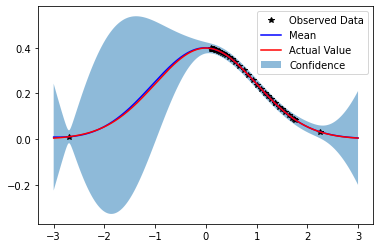

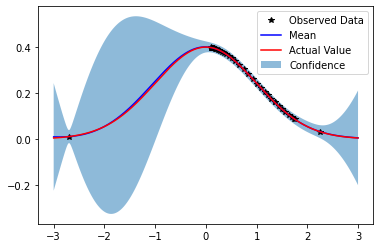

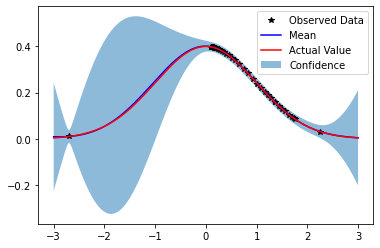

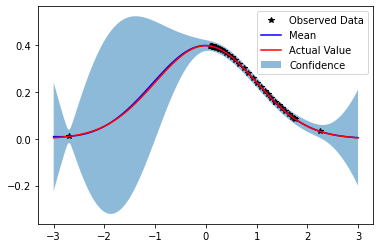

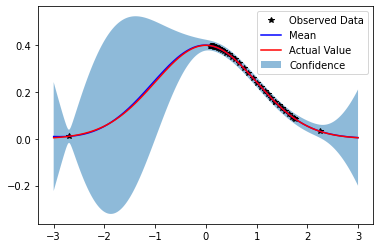

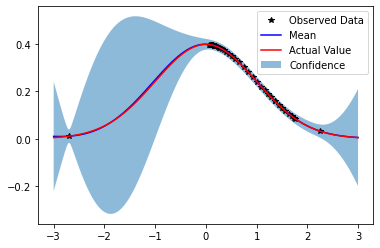

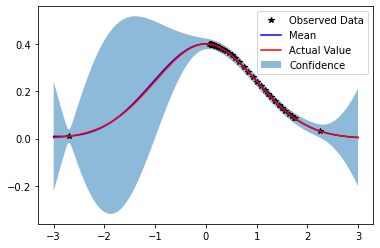

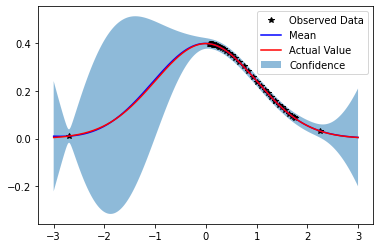

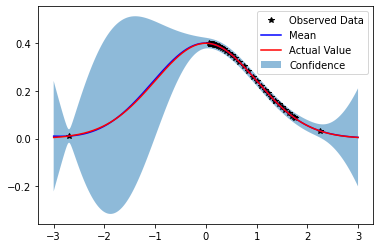

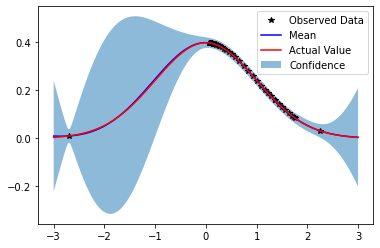

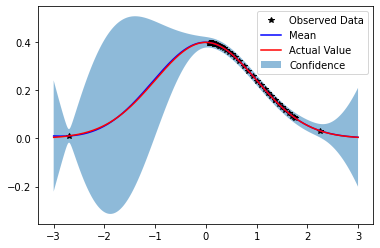

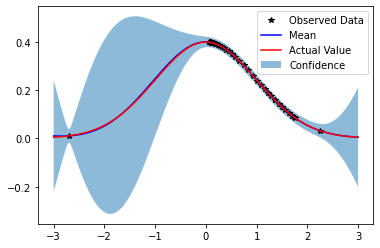

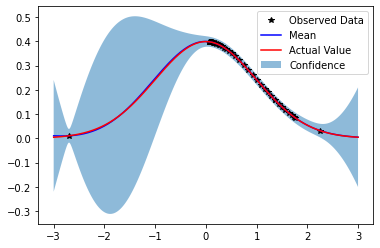

In [10]:
area1 = []
area2 = []
for i in range(50):
  model = ExactGPModel(X_sample, y_sample, likelihood)
  model.train()
  likelihood.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  for i in range(10):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_sample)
    # Calc loss and backprop gradients
    loss = -mll(output, y_sample)
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = X
    observed_pred = likelihood(model(test_x))
  with torch.no_grad():
    # Initialize plot
    #f, ax = plt.subplots()
    # Get standard deviation
    std = np.sqrt(observed_pred.variance.numpy())
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    mean = observed_pred.mean.numpy()
    #lower, upper = mean - std, mean + std
    # Plot training data as black stars
    plt.plot(X_sample.numpy(), y_sample.numpy(), 'k*')
    # Plot predictive means as blue line
    plt.plot(test_x.numpy(), mean, 'b')
    # Plot actual function as red line
    plt.plot(test_x.numpy(), y.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #plt.ylim([0, 1])
    plt.legend(['Observed Data', 'Mean', 'Actual Value','Confidence'])
    plt.show()
  mu = observed_pred.mean
  sigma = torch.sqrt(observed_pred.variance)
  idx = torch.argmax(mu - sigma * math.sqrt(25))
  p = torch.unsqueeze(X[idx], 0)
  y_int = observed_pred.mean.numpy()  
  area1.append(trapz(y_int, dx=0.005))
  area2.append(simps(y_int, dx=0.005))
  X_sample = torch.cat((X_sample, p))
  y_sample = gaussian_2(X_sample)     

In [11]:
area1

[0.46985146,
 0.45550972,
 0.47954535,
 0.532275,
 0.60397065,
 0.68870556,
 0.7613909,
 0.8046127,
 0.83454067,
 0.8782693,
 0.93058014,
 0.97619474,
 1.0162325,
 1.0488658,
 1.075082,
 1.0933524,
 1.1013944,
 1.101099,
 1.0953336,
 1.0872905,
 1.0784783,
 1.0693498,
 1.0604893,
 1.0523299,
 1.0450916,
 1.0399368,
 1.0356573,
 1.0299623,
 1.0262535,
 1.0234492,
 1.0208738,
 1.0186971,
 1.0167661,
 1.0149992,
 1.0133471,
 1.0119575,
 1.0103891,
 1.0088645,
 1.00757,
 1.0065784,
 1.0056664,
 1.0051606,
 1.0040245,
 1.0035623,
 1.0029967,
 1.0025978,
 1.0020045,
 1.001591,
 1.0012307,
 1.0006799]

In [12]:
area2

[0.4698514980636537,
 0.45550974101759495,
 0.47954539251048117,
 0.5322750299889595,
 0.6039706756919623,
 0.6887055463716387,
 0.7613908313307911,
 0.8046125659625978,
 0.8345405224896968,
 0.8782692500948905,
 0.9305800076760352,
 0.9761946349404752,
 1.0162325125839562,
 1.0488658404629678,
 1.0750819305237382,
 1.0933525260724126,
 1.101394547438249,
 1.1010989497043193,
 1.0953336585871876,
 1.0872906697541476,
 1.0784783211816102,
 1.0693497273605317,
 1.0604894662834703,
 1.0523299597296865,
 1.0450917294621467,
 1.0399368030112237,
 1.0356573313614355,
 1.0299622943438589,
 1.0262534690601752,
 1.0234493100084365,
 1.0208739538164808,
 1.018697115960531,
 1.0167662082286553,
 1.014999228878878,
 1.0133471765043214,
 1.0119575911434366,
 1.0103891569562256,
 1.0088646077178418,
 1.0075699846213684,
 1.0065784336440264,
 1.0056665015639736,
 1.0051605923939497,
 1.0040245381835848,
 1.003562382538803,
 1.002996675488539,
 1.0025977987190708,
 1.0020045804511755,
 1.0015909481979

In [13]:
plot_1 = []
plot_2 = []
for i in range(0,len(area1),5):
  plot_1.append(area1[i])
  plot_2.append(area2[i])

In [14]:
size = list(X_sample.shape)

In [15]:
x = []
for i in range(3, size[0], 5):
  x.append(i)

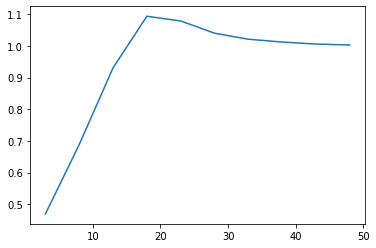

In [16]:
plt.plot(x,plot_1)
plt.show()

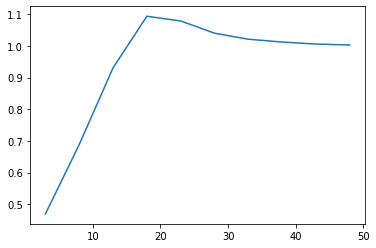

In [17]:
plt.plot(x, plot_2)
plt.show()

In [18]:
area = trapz(y, dx=0.005)

In [19]:
area


0.99646914

In [20]:
X_sample[0:3]

tensor([ 1.3567,  2.2485, -2.6980])